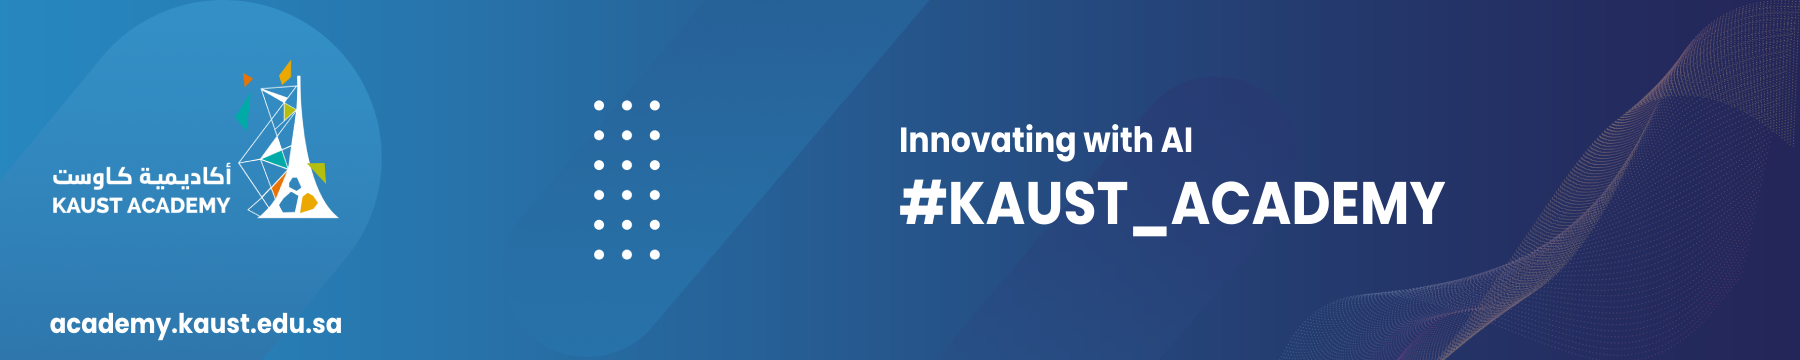

This notebook has been inspired from [REINFORCEMENT LEARNING (DQN) TUTORIAL](https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html) and [reinforcement_q_learning](https://colab.research.google.com/github/pytorch/tutorials/blob/gh-pages/_downloads/reinforcement_q_learning.ipynb#scrollTo=ChfTgUJGcvEA) by Paszke & Towers.

# Deep Q-Learning

In this notebook, we will implement Deep Q-Learning Reinforcement learning algorithm for Cart Pole Environment.

## Cartpole

As the image below shows, the goal of the agent is to balance a verticle rod on the top of the car. This position is unstable and that is the main reason for the difficulty.

![Cartpole](https://gymnasium.farama.org/_images/cart_pole.gif)

The problem is solved if the average of the agent's scores is greater than 195 gathered in 100 episodes.
The agent receives reward 1 in each timestep until the psoition of the rod is correct (not inclined too far away from the vertical position).

The episode ends if any one of the following occurs:
- Pole Angle is greater than ±12°
- Cart Position is greater than ±2.4 (center of the cart reaches the edge of the display)
- Episode length is greater than 500 (200 for v0)

The state is low dimensional and cosists of:
* position
* velocity
* angle
* angular velocity

You can read more the cartpole environment [here](https://gymnasium.farama.org/environments/classic_control/cart_pole/)

## Deep Q-Learning

The main idea behind Q-learning is that if we had a function
$Q^*: State \times Action \rightarrow \mathbb{R}$, that could tell
us what our return would be, if we were to take an action in a given
state, then we could easily construct a policy that maximizes our
rewards:

\begin{align}\pi^*(s) = \arg\!\max_a \ Q^*(s, a)\end{align}

But this is not scalable. Must compute $Q(s,a)$ for every state-action pair. If state is e.g. current game state pixels, computationally infeasible to compute for entire state space! But, since neural networks are universal function
approximators, we can simply create one and train it to resemble
$Q^*$.

For our training update rule, we'll use a fact that every $Q$
function for some policy obeys the Bellman equation:

\begin{align}Q^{\pi}(s, a) = r + \gamma Q^{\pi}(s', \pi(s'))\end{align}

The difference between the two sides of the equality is known as the
temporal difference error, $\delta$:

\begin{align}\delta = Q(s, a) - (r + \gamma \max_a Q(s', a))\end{align}

To minimise this error, we will use the `Huber
loss <https://en.wikipedia.org/wiki/Huber_loss>`__. The Huber loss acts
like the mean squared error when the error is small, but like the mean
absolute error when the error is large - this makes it more robust to
outliers when the estimates of $Q$ are very noisy. We calculate
this over a batch of transitions, $B$, sampled from the replay
memory:

\begin{align}\mathcal{L} = \frac{1}{|B|}\sum_{(s, a, s', r) \ \in \ B} \mathcal{L}(\delta)\end{align}

\begin{align}\text{where} \quad \mathcal{L}(\delta) = \begin{cases}
     \frac{1}{2}{\delta^2}  & \text{for } |\delta| \le 1, \\
     |\delta| - \frac{1}{2} & \text{otherwise.}
   \end{cases}\end{align}



In [ ]:
import gymnasium as gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

In [ ]:
# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Create the environment
env = gym.make("CartPole-v1", render_mode="rgb_array")

### Experience Replay

Learning from batches of consecutive samples is problematic as the sample are correlated and it can create a bad feedback loop if one action is dominated in the samples.

We can address these problems using an experience replay memory. It maintains a record for all the transitions experienced. The agent is then trained by sampling random minibatches from the replay memory.

In [ ]:
# Named tuple representing a single transition in our environment
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward', 'done'))

# Cyclic buffer of bounded size that holds and samples the transitions observed recently
class ReplayMemory(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

### Q-Network

In [ ]:
# A neural network approximater for Q-Value.
# It takes the state as input and predicts the Q-value for all actions at that state
class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

### Exploration vs Exploitation

Notice that Q-learning only learns about the states and actions it visits. What if an optimal state remains unvisited due to not being explored. The agent should sometimes pick suboptimal actions in order to visit new states and actions. <br>

A simple strategy is to use an $\epsilon$-greedy policy. According to this policy, the agent takes a random action with epsilon probability. The value of epsilon is high at the start of training and low towards the end. So, the agent explores more at the start and then exploit the learned policy more at the end.

### Hyperparameters

In [ ]:
# Here, we will specify the hyperparameters

total_episodes = 1000         # Total training episodes
max_steps = 200              # Max steps per episode
learning_rate = 1e-3         # Learning rate|
gamma = 0.99                 # Discounting rate
batch_size = 128             # Training Batch size
target_update = 5            # Target network update frequency
train_frquency = 1           # Train Q network every train_frquency episodes
train_epochs = 2             # Training epochs during each training cycle

# Exploration parameters
epsilon = 1.0                 # Exploration rate
max_epsilon = 1.0             # Exploration probability at start
min_epsilon = 0.01            # Minimum exploration probability
decay_rate = 0.003            # Exponential decay rate for exploration prob

### Training

In [ ]:
print('observation space:', env.observation_space)
print('action space:', env.action_space)

########################### TODO ###########################
## get your state_size and action_size from the environment
state_size =
action_size =
############################################################

print('state size:', state_size)
print('action size:', action_size)

observation space: Box([-4.8               -inf -0.41887903        -inf], [4.8               inf 0.41887903        inf], (4,), float32)
action space: Discrete(2)
state size: 4
action size: 2


In [ ]:
# Intialize both Q-networks
policy_net = DQN(state_size, action_size).to(device)
target_net = DQN(state_size, action_size).to(device)

# update target network
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

# set up the optimizer
optimizer = optim.RMSprop(policy_net.parameters(), lr=learning_rate)

# Initialize the replay buffer
memory = ReplayMemory(10000)

In [ ]:
def get_action(state):

    ########################### TODO ###########################
    # get action for current state according to the greedy policy
    ## First we randomize a number
    ## If this number > greater than epsilon --> exploitation (taking the biggest Q value for this state)
    # Else doing a random choice --> exploration

    action =

    ############################################################

    return action


In [ ]:
# List of rewards
rewards = []

for episode in range(1, total_episodes+1):
    # Initialize the environment and state
    state, _ = env.reset()
    state = torch.tensor([state], device=device)
    total_rewards = 0
    for _ in range(max_steps):
        # Select and perform an action
        action = get_action(state)
        next_state, reward, terminated, truncated, _ = env.step(action.item())
        done = terminated or truncated

        total_rewards += reward

        reward = torch.tensor([reward], device=device)
        done = torch.tensor([int(done)], device=device)
        next_state = torch.tensor([next_state], device=device)

        # Store the transition in memory
        memory.push(state, action, next_state, reward, done)

        # Move to the next state
        state = next_state

        if done:
            break

    # optimize the policy
    if episode % train_frquency == 0 and len(memory) >= batch_size:
      for _ in range(train_epochs):
        # get samples from experience replay memory
        transitions = memory.sample(batch_size)
        # unroll and reroll to get them in proper format
        batch = Transition(*zip(*transitions))

        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        next_state_batch = torch.cat(batch.next_state)
        reward_batch = torch.cat(batch.reward)
        done_batch = torch.cat(batch.done)

        ########################### TODO ###########################
        # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
        # columns of actions taken
        state_action_values =
        ############################################################

        ########################### TODO ###########################
        # Compute V(s_{t+1}) for all next states and get the max q values.
        with torch.no_grad():
          next_state_values =
        ############################################################

        ########################### TODO ###########################
        # Compute the target Q values
        target_q_values =
        ############################################################

        ########################### TODO ###########################
        # Compute Huber loss
        loss =
        ############################################################

        # Optimize the model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


    # Update the target network
    if episode % target_update == 0:
        target_net.load_state_dict(policy_net.state_dict())

    # Reduce epsilon (because we need less and less exploration)
    epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*episode)
    rewards.append(total_rewards)
    print(f"Episode {episode}: Reward = {total_rewards}, Epsilon = {epsilon}")

/tmp/ipython-input-10-1813792144.py:7: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  state = torch.tensor([state], device=device)


Episode 1: Reward = 10.0, Epsilon = 0.9970344505483393
Episode 2: Reward = 37.0, Epsilon = 0.9940777844133959
Episode 3: Reward = 12.0, Epsilon = 0.9911299749851548
Episode 4: Reward = 16.0, Epsilon = 0.9881909957333113
Episode 5: Reward = 12.0, Epsilon = 0.985260820207032
Episode 6: Reward = 24.0, Epsilon = 0.9823394220347178
Episode 7: Reward = 17.0, Epsilon = 0.979426774923765
Episode 8: Reward = 23.0, Epsilon = 0.9765228526603302
Episode 9: Reward = 16.0, Epsilon = 0.9736276291090934
Episode 10: Reward = 30.0, Epsilon = 0.970741078213023
Episode 11: Reward = 25.0, Epsilon = 0.9678631739931417
Episode 12: Reward = 14.0, Epsilon = 0.9649938905482919
Episode 13: Reward = 13.0, Epsilon = 0.962133202054903
Episode 14: Reward = 29.0, Epsilon = 0.9592810827667597
Episode 15: Reward = 24.0, Epsilon = 0.9564375070147689
Episode 16: Reward = 11.0, Epsilon = 0.9536024492067297
Episode 17: Reward = 15.0, Epsilon = 0.9507758838271028
Episode 18: Reward = 45.0, Epsilon = 0.9479577854367803
Episo

Text(0, 0.5, 'Reward')

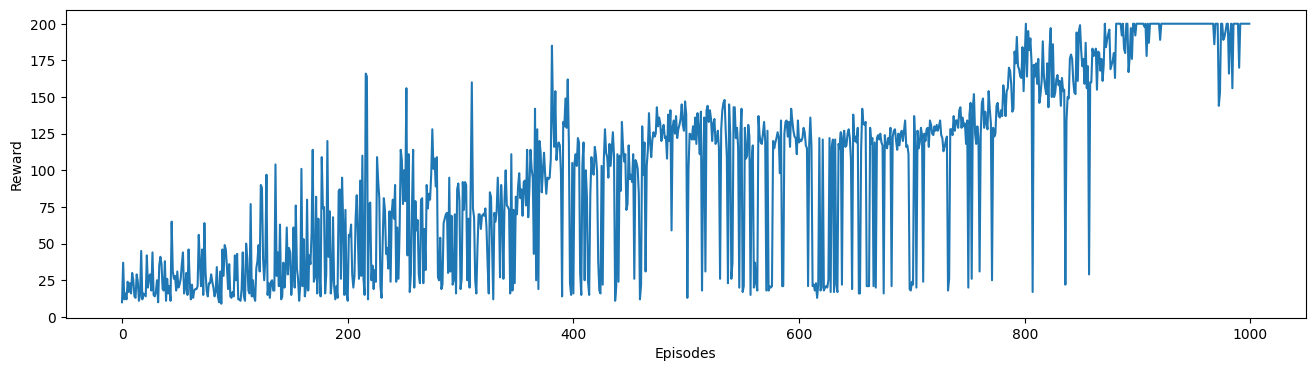

In [ ]:
plt.figure(figsize=(16,4))
plt.plot(rewards)
plt.xlabel("Episodes")
plt.ylabel("Reward")

### Visualization

In [ ]:
# For visualization
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display
import glob
import base64, io, os

os.environ['SDL_VIDEODRIVER']='dummy'

In [ ]:
os.makedirs("video", exist_ok=True)

def show_video(env_name):
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = 'video/{}.mp4'.format(env_name)
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")

def show_video_of_model(env_name):
    vid = video_recorder.VideoRecorder(env, path="video/{}.mp4".format(env_name))
    state, _ = env.reset()
    state = torch.tensor([state], device=device)
    done = False
    for t in range(max_steps):
        vid.capture_frame()
        action = get_action(state)
        next_state, reward, terminated, truncated, info = env.step(action.item())
        done = terminated or truncated
        next_state = torch.tensor([next_state], device=device)
        # print(f"state: {state}, action: {action.item()}",next_state, reward, done)
        state = next_state
        if done:
            break
    vid.close()
    env.close()

In [ ]:
show_video_of_model("CartPole-v1")

/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


In [ ]:
show_video("CartPole-v1")